In [134]:
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ELU
from keras.optimizers import Adamax
import numpy as np
from sklearn import svm, ensemble
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_auc_score
import xgboost
import matplotlib.pyplot as plt
from yellowbrick.features import PCA
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay

### Loading the prepared JSON train and test datasets.

In [80]:
train_dataset = json.load(open("TrainingSet.json", "r"))
test_dataset = json.load(open("TestSet.json", "r"))

### Merge features into a feature vector.

In [81]:
X = []
y = []

for dataset in [train_dataset, test_dataset]:
    x = np.array([dataset["ZCR"], dataset["Flatness"], dataset["SpectralCentroid"], dataset["F0"], dataset["Tempo"],
                  dataset["Kurtosis"]])
    x = x.reshape(x.shape[1], x.shape[0])
    x2 = np.concatenate([dataset["Contrast"], dataset["MFCCs"], dataset["Chroma"], dataset["Mel"]], axis=1)
    x = np.concatenate([x, x2], axis=1)
    x = np.array(x, dtype=float)
    X.append(x)
    y.append(np.array(dataset["labels"], dtype=int))

In [82]:
X[0].shape

(18000, 73)

In [83]:
X_train, X_test, y_train, y_test = X[0], X[1], y[0], y[1]

##### Normalization of the training data and using the same scale on test data.

In [84]:
scaler_mm = MinMaxScaler()
scaler_r = RobustScaler()

X_train_normalized_mm = scaler_mm.fit_transform(X_train)
X_test_normalized_mm= scaler_mm.transform(X_test)

X_train_normalized_r = scaler_r.fit_transform(X_train)
X_test_normalized_r = scaler_r.transform(X_test)

### Dataset visualization

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yellowbrick/features/pca.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


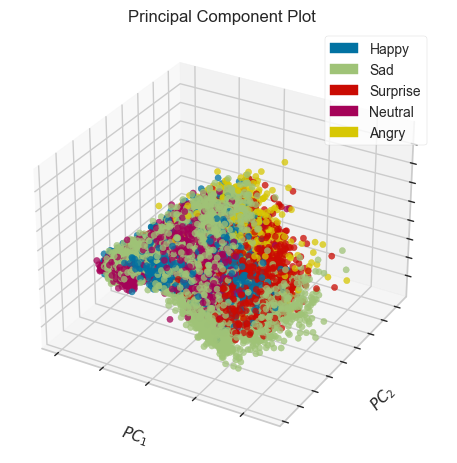

<Axes3D: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$', zlabel='$PC_3$'>

In [85]:
pca = PCA(projection=3, scale=True, classes=train_dataset["classes"])
pca.fit_transform(np.concatenate(X, axis=0), np.concatenate(y, axis=0))
pca.show()

In [86]:
tsne = TSNE(n_components=3, random_state=0).fit_transform(X_train)

[Text(0.5, 1.0, 'T-SNE projection')]

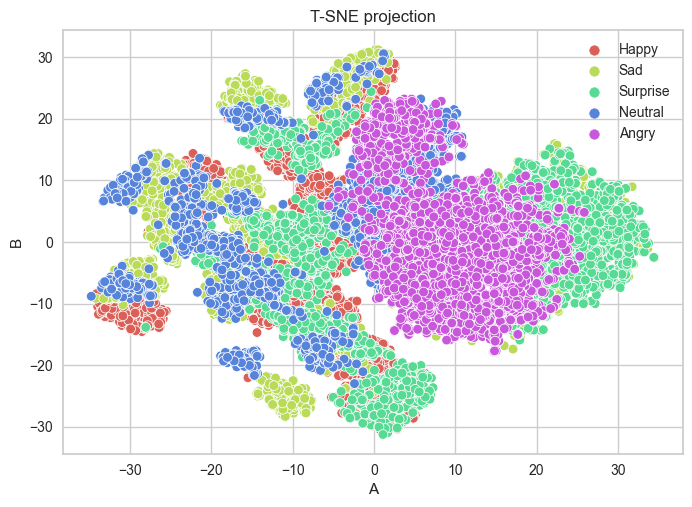

In [87]:
df = pd.DataFrame()
df["y"] = y_train
df["A"] = tsne[:,0]
df["B"] = tsne[:,1]

sns.scatterplot(x="A", y="B", hue=[train_dataset["classes"][c] for c in df.y.tolist()],
                palette=sns.color_palette("hls", 5),
                data=df).set(title="T-SNE projection") 

### Neural network model construction

In [125]:
nn_model = Sequential()
nn_model.add(Dense(800, input_dim=73, activation='linear'))
nn_model.add(ELU(alpha=0.01))
nn_model.add(Dense(500, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(240, activation='relu'))
nn_model.add(BatchNormalization(momentum=0.79, scale=False))
nn_model.add(Dense(50, activation="sigmoid"))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(5, activation='softmax'))
nn_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adamax(learning_rate=0.0003), metrics=['accuracy'])

In [126]:
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=10, use_multiprocessing=True, max_queue_size=13)

Epoch 1/50
1800/1800 [==============================] - 7s 4ms/step - loss: 1.0617 - accuracy: 0.5519
Epoch 2/50
1800/1800 [==============================] - 6s 4ms/step - loss: 0.8562 - accuracy: 0.6406
Epoch 3/50
1800/1800 [==============================] - 6s 4ms/step - loss: 0.7539 - accuracy: 0.6893
Epoch 4/50
1800/1800 [==============================] - 6s 4ms/step - loss: 0.6865 - accuracy: 0.7214
Epoch 5/50
1800/1800 [==============================] - 6s 4ms/step - loss: 0.6259 - accuracy: 0.7481
Epoch 6/50
1800/1800 [==============================] - 6s 4ms/step - loss: 0.5865 - accuracy: 0.7679
Epoch 7/50
1800/1800 [==============================] - 6s 4ms/step - loss: 0.5548 - accuracy: 0.7832
Epoch 8/50
1800/1800 [==============================] - 7s 4ms/step - loss: 0.5147 - accuracy: 0.8005
Epoch 9/50
1800/1800 [==============================] - 7s 4ms/step - loss: 0.4904 - accuracy: 0.8132
Epoch 10/50
1800/1800 [==============================] - 6s 4ms/step - loss: 0.476

In [144]:
nn_predictions1 = nn_model.predict(X_test)

375/375 [==============================] - 1s 2ms/step


In [145]:
nn_predictions1.shape

(12000, 5)

In [146]:
nn_predictions = np.argmax(nn_predictions1, axis=1)

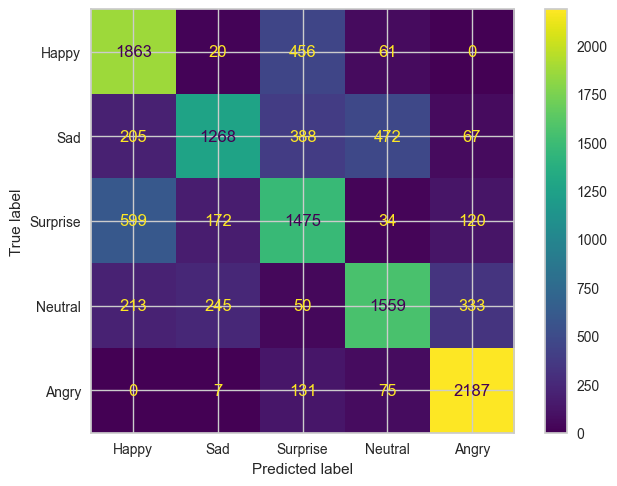

In [147]:
ConfusionMatrixDisplay(confusion_matrix(y_test, nn_predictions), display_labels=train_dataset["classes"]).plot()

In [94]:
nn_acc, nn_f1 = accuracy_score(y_test, nn_predictions), f1_score(y_test, nn_predictions, average=None)
nn_acc, nn_f1

(0.6923333333333334,
 array([0.73044183, 0.64275798, 0.6013363 , 0.62650602, 0.82770998]))

### SVM

In [159]:
svm_model = svm.SVC(kernel="rbf", C=10, shrinking=False, break_ties=True, probability=True)
svm_model.fit(X_train_normalized_mm, y_train)

SVC(C=10, break_ties=True, probability=True, shrinking=False)

In [164]:
svm_predictions = svm_model.predict(X_test_normalized_mm)

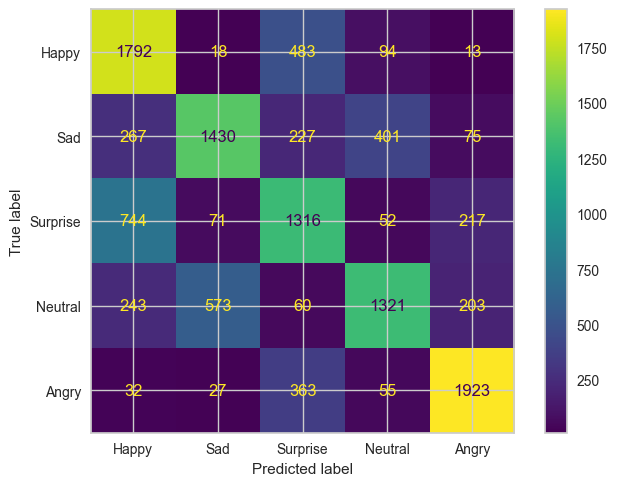

In [165]:
ConfusionMatrixDisplay(confusion_matrix(y_test, svm_predictions), display_labels=train_dataset["classes"]).plot()

In [166]:
svm_acc, svm_f1 = accuracy_score(y_test, svm_predictions), f1_score(y_test, svm_predictions, average=None)
svm_acc, svm_f1

(0.6485, array([0.65425338, 0.63288338, 0.54279233, 0.61114966, 0.79610847]))

### Random Forest

In [99]:
rf_model = ensemble.RandomForestClassifier(n_estimators=650, criterion="entropy")
rf_model.fit(X_train_normalized_r, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=650)

In [100]:
rf_predictions = rf_model.predict(X_test_normalized_r)

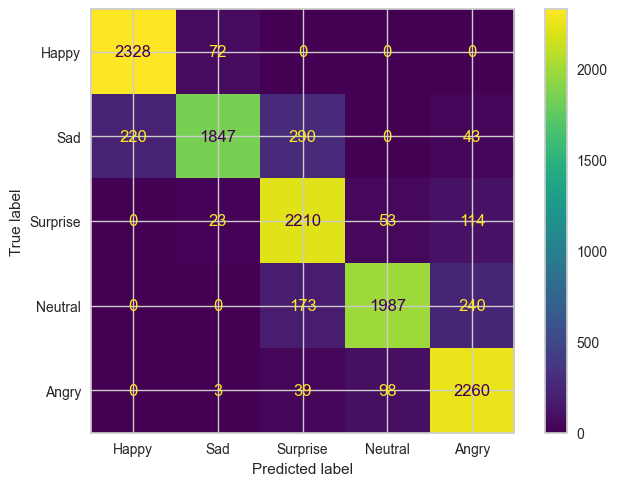

In [101]:
ConfusionMatrixDisplay(confusion_matrix(y_test, rf_predictions), display_labels=train_dataset["classes"]).plot()

In [103]:
rf_acc, rf_f1 = accuracy_score(y_test, rf_predictions), f1_score(y_test, rf_predictions, average=None)
rf_acc, rf_f1

(0.886, array([0.94098626, 0.85017261, 0.86463224, 0.87571617, 0.89381056]))

### XGBoost

In [104]:
xgboost_model = xgboost.XGBClassifier(n_estimators=311, booster="dart", sampling_method="gradient_based", 
                      eta=0.008, max_depth=15, tree_method="hist", grow_policy="lossguide",
                      sample_type="weighted", normalize_type="forest")
xgboost_model.fit(X_train_normalized_r, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.008, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=311, n_jobs=None, normalize_type='forest',
              num_parallel_tree=None, ...)

In [105]:
xgboost_predictions = xgboost_model.predict(X_test_normalized_r)

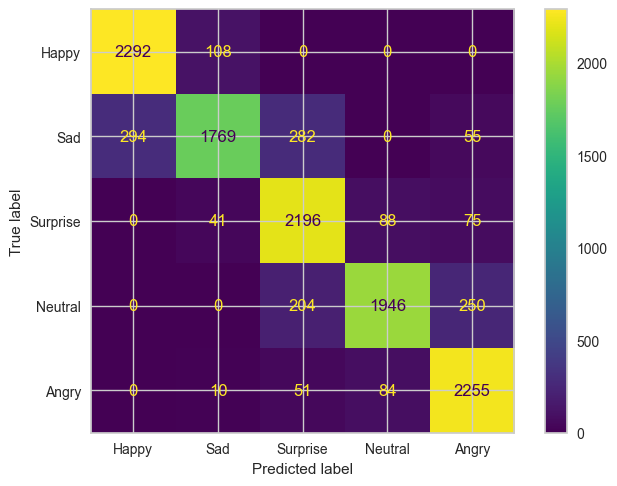

In [106]:
ConfusionMatrixDisplay(confusion_matrix(y_test, xgboost_predictions), display_labels=train_dataset["classes"]).plot()

In [107]:
xgboost_acc, xgboost_f1 = accuracy_score(y_test, xgboost_predictions), f1_score(y_test, xgboost_predictions, average=None)
xgboost_acc, xgboost_f1

(0.8715, array([0.91937425, 0.81746765, 0.85563998, 0.86144312, 0.89572989]))

### AdaBoost

In [108]:
adaboost_model = AdaBoostClassifier(n_estimators=1000, 
                                    estimator=DecisionTreeClassifier(max_depth=10, criterion='entropy'))
adaboost_model.fit(X_train_normalized_r, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=10),
                   n_estimators=1000)

In [109]:
adaboost_predictions = adaboost_model.predict(X_test_normalized_r)

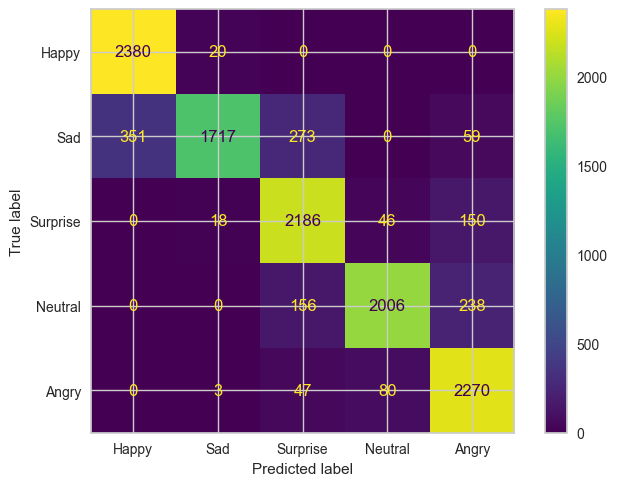

In [110]:
ConfusionMatrixDisplay(confusion_matrix(y_test, adaboost_predictions), display_labels=train_dataset["classes"]).plot()

In [111]:
adaboost_acc, adaboost_f1 = accuracy_score(y_test, adaboost_predictions), f1_score(y_test, adaboost_predictions, average=None)
adaboost_acc, adaboost_f1

(0.8799166666666667,
 array([0.92769441, 0.82587783, 0.86369024, 0.88526037, 0.88723862]))

### Model comparison

Text(0.5, 1.0, 'Accuracy comparison')

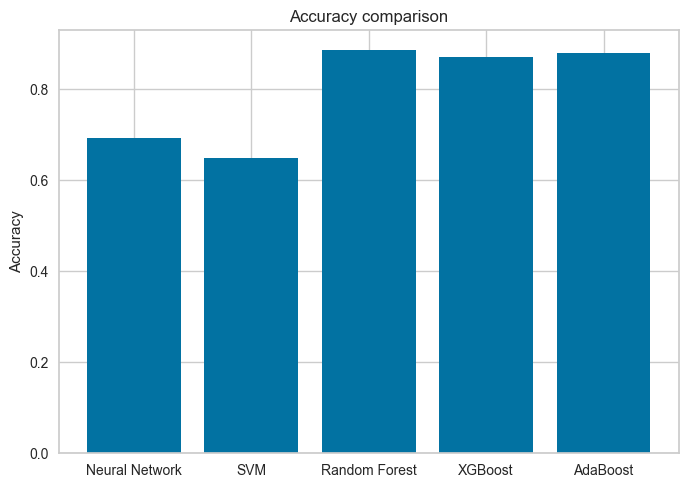

In [116]:
models = ["Neural Network", "SVM", "Random Forest", "XGBoost", "AdaBoost"]
accuracies = [nn_acc, svm_acc, rf_acc, xgboost_acc, adaboost_acc]
f1_scores = [np.mean(x) for x in [nn_f1, svm_f1, rf_f1, xgboost_f1, adaboost_f1]]

plt.bar(models, accuracies, align='center', alpha=1)
plt.ylabel('Accuracy')
plt.title('Accuracy comparison')

#### Clearly, the ensemble methods show an extreme advantage.

In [173]:
lb = LabelBinarizer().fit(y_train)
one_hot_y_test = lb.transform(y_test)

375/375 [==============================] - 1s 2ms/step


Text(0, 0.5, 'True Positive Rate')

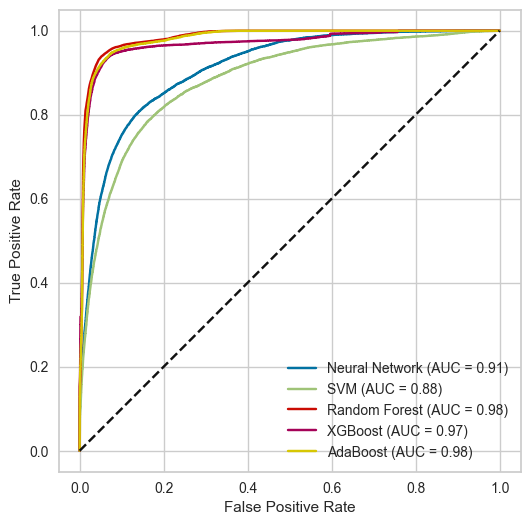

In [177]:
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(
    one_hot_y_test.ravel(),
    nn_model.predict(X_test).ravel(),
    name="Neural Network", ax=ax)
RocCurveDisplay.from_predictions(
    one_hot_y_test.ravel(),
    svm_model.predict_proba(X_test_normalized_mm).ravel(),
    name="SVM", ax=ax)
RocCurveDisplay.from_predictions(
    one_hot_y_test.ravel(),
    rf_model.predict_proba(X_test_normalized_r).ravel(),
    name="Random Forest", ax=ax)
RocCurveDisplay.from_predictions(
    one_hot_y_test.ravel(),
    xgboost_model.predict_proba(X_test_normalized_r).ravel(),
    name="XGBoost", ax=ax)
RocCurveDisplay.from_predictions(
    one_hot_y_test.ravel(),
    adaboost_model.predict_proba(X_test_normalized_r).ravel(),
    name="AdaBoost", ax=ax)
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")